In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast
import seaborn as sns

dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# data cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills']=df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)

### What is the most optimal skill to learn for Data Analysts?

In [3]:
# Data Prep
df_us_da = df[(df['job_country'] == "United States") & (df['job_title_short'] == 'Data Analyst') & (df['salary_year_avg'].notna())].copy()
df_us_da_skills = df_us_da.explode("job_skills")
df_us_da_skills[['salary_year_avg','job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [13]:
df_da_skills_stats=(df_us_da_skills.groupby(by=['job_skills'])
  .agg(
    median_salary=('salary_year_avg','median'), 
    skill_count=('job_skills','count')
   )
  .sort_values(by='skill_count',ascending=False)
  #.head(skill_count)
)

In [ ]:
# Alternatively - can use generic agg funvtions & rename resulting columns
# df_da_skills_stats=(df_us_da_skills.groupby(by=['job_skills'])
#   .agg(['count','median'])
#   .sort_values(by='count',ascending=False)
#   #.head(skill_count)
# )
# df_da_skill_stats=df_da_skill_stats.rename(columns={'count':'skill_count','median':'median_salary'})

In [14]:
df_da_skills_stats

,median_salary,skill_count
job_skills,,
sql,91000.0,2508
excel,84392.0,1808
python,97500.0,1431
tableau,92875.0,1364
sas,90000.0,926
...,...,...
couchbase,160515.0,1
chainer,100000.0,1
chef,85000.0,1


In [15]:
df_us_jobs_count = len(df_us_da)
df_da_skills_stats['skill_pct'] = 100* df_da_skills_stats['skill_count'] / df_us_jobs_count

In [16]:
df_da_skills_stats['skill_pct'] = 100* df_da_skills_stats['skill_count'] / df_us_jobs_count

In [17]:
skill_percent=5
df_da_skills_high_demand = df_da_skills_stats[df_da_skills_stats['skill_pct']>=skill_percent]	
df_da_skills_high_demand

,median_salary,skill_count,skill_pct
job_skills,,,
sql,91000.00,2508,57.655172
excel,84392.00,1808,41.563218
python,97500.00,1431,32.896552
tableau,92875.00,1364,31.356322
sas,90000.00,926,21.287356
r,92500.00,893,20.528736
power bi,90000.00,838,19.264368
powerpoint,85000.00,462,10.620690
word,81194.75,461,10.597701


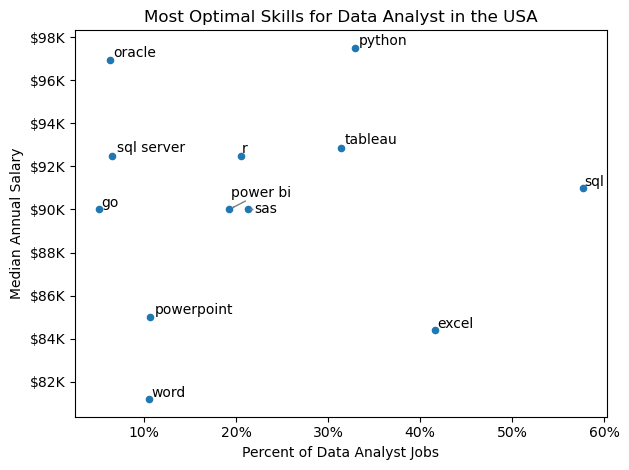

In [60]:
# Plot
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter,PercentFormatter

df_da_skills_high_demand.plot(kind='scatter', x='skill_pct', y='median_salary')

texts = []

for (i,job_skill) in enumerate(df_da_skills_high_demand.index):
  texts.append(plt.text(df_da_skills_high_demand['skill_pct'].iloc[i], df_da_skills_high_demand['median_salary'].iloc[i], job_skill))

adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray', lw=1))

ax = plt.gca()
#ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f"{int(x)}%"))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"${int(y/1000)}K"))

plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Annual Salary')
plt.title(f"Most Optimal Skills for Data Analyst in the USA")
plt.tight_layout()
plt.show()

In [ ]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

In [56]:
df_technology = pd.DataFrame(data=list(technology_dict.items()),columns=['technology','skills'])
df_technology = df_technology.explode("skills")
df_technology = df_technology.groupby(by=['skills']).first().reset_index()

In [58]:
#df_da_skills_high_demand.merge(df_technology_unique, how='left', left_on=df_da_skills_high_demand.index, right_on='skills')
df_da_skills_high_demand_tech = df_da_skills_high_demand.merge(df_technology, how='left', left_on='job_skills', right_on='skills')

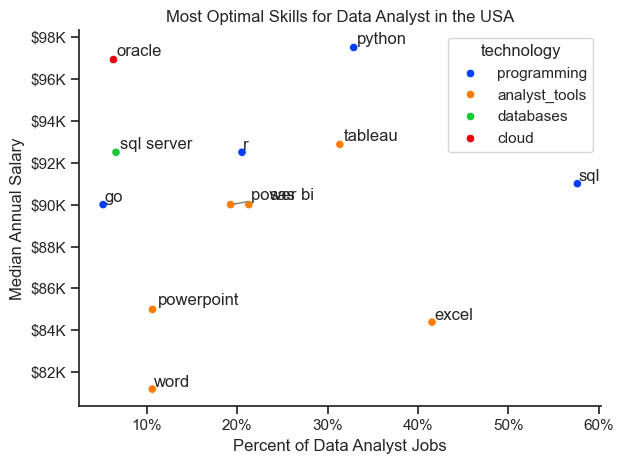

In [65]:
# Plot with technology categories
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter,PercentFormatter

# df_da_skills_high_demand_tech.plot(kind='scatter', x='skill_pct', y='median_salary')
sns.set_theme(style="ticks")
sns.scatterplot(
  data=df_da_skills_high_demand_tech,
  x='skill_pct', 
  y='median_salary',
  hue='technology',
  palette='bright',
  legend='full'
)
sns.despine()

texts = []

for (i,job_skill) in enumerate(df_da_skills_high_demand_tech["skills"]):
  texts.append(plt.text(df_da_skills_high_demand_tech['skill_pct'].iloc[i], df_da_skills_high_demand_tech['median_salary'].iloc[i], job_skill))

adjust_text(texts,arrowprops=dict(arrowstyle='->', color='gray', lw=1))

ax = plt.gca()
#ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,_: f"{int(x)}%"))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"${int(y/1000)}K"))

plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Annual Salary')
plt.title(f"Most Optimal Skills for Data Analyst in the USA")
plt.tight_layout()
plt.show()

In [61]:
df_da_skills_high_demand_tech

,median_salary,skill_count,skill_pct,skills,technology
0,91000.00,2508,57.655172,sql,programming
1,84392.00,1808,41.563218,excel,analyst_tools
2,97500.00,1431,32.896552,python,programming
3,92875.00,1364,31.356322,tableau,analyst_tools
4,90000.00,926,21.287356,sas,analyst_tools
5,92500.00,893,20.528736,r,programming
6,90000.00,838,19.264368,power bi,analyst_tools
7,85000.00,462,10.620690,powerpoint,analyst_tools
8,81194.75,461,10.597701,word,analyst_tools
9,92500.00,286,6.574713,sql server,databases
